# Tarea 2: Segmentación

El objetivo de esta tarea es conocer mejor a nuestra base de clientes en 7 u 8 grupos de clientes similares con el fin de orientar la actividad comercial de la empresa. Se pide también poder identificar y poder saber cómo son los clientes que pertenecen a cada uno de estos grupos.

Este es un problema de Machine Learning no supervisado concretamente de asociación (o *clustering*). 

Existen 3 grandes métodos para afrontar este problema:
- KMeans
- Hierarchical clustering
- DBSCAN

## **K-means**

K-means (o K-medias) es un método de agrupamiento, que tiene como objetivo la partición de un conjunto de n observaciones en k grupos en el que cada observación pertenece al grupo cuyo valor medio es más cercano. [[2]] 
https://es.wikipedia.org/wiki/K-medias

### **Atributos a seleccionar y preparación de los datos**
 
 - (X) 0 : pk_cid (integer). Para hacer tracking al finalizar
 - 1 : pk_partition (object)
 - 2 : entry_date (object) 
 - (X) 3 : entry_channel (category)
 - (X) 4 : active_customer (float64)
 - 5 : segment (category)
 - (X) 6 : short_term_deposit (bool)
 - (X) 7 : loans (bool)
 - (X) 8 : mortgage (bool)
 - (X) 9 : funds (bool)   
 - (X) 10 : securities (bool)
 - (X) 11 : long_term_deposit (bool)
 - (X) 12 : em_account_pp (bool)
 - (X) 13 : credit_card (bool)
 - (X) 14 : payroll (bool)
 - (X) 15 : pension_plan (bool)
 - (X) 16 : payroll_account (bool)
 - (X) 17 : emc_account (bool)
 - (X) 18 : debit_card (bool)   
 - (X) 19 : em_account_p (bool)
 - (X) 20 : em_acount (bool)
 - (X) 21 : country_id (bool)
 - (X) 22 : region_code (bool)
 - (X) 23 : gender (bool). Se debe pasar a bool
 - (X) 24 : age (integer)
 - 25 : deceased (bool)
 - (X) 26 : salary (float64)

In [ ]:
!ls -lh

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

In [3]:
from cleaning_data import clean_commercial_activity

commercial_activity_all = pd.read_csv('./data/commercial_activity_df.csv', index_col=0)
partitions = commercial_activity_all['pk_partition'].unique()
partitions = sorted(partitions)

commercial_activity_df = clean_commercial_activity(commercial_activity_all, partitions)

# Liberamos espacio en la memoria
del commercial_activity_all

In [4]:
sociodemographic_df = pd.read_csv('./data/sociodemographic_clean.csv', index_col=0)

In [5]:
from cleaning_data import clean_products

products_all = pd.read_csv('./data/products_df.csv', index_col=0)
partitions = products_all['pk_partition'].unique()
partitions = sorted(partitions)

products_df = clean_products(products_all, partitions)

del products_all

In [6]:
comm_prod_socio = pd.merge(commercial_activity_df, products_df, on=['pk_cid','pk_partition'], how='outer')
comm_prod_socio = pd.merge(comm_prod_socio, sociodemographic_df, on=['pk_cid','pk_partition'], how='outer')

In [9]:
#df_description(comm_prod_socio)

NameError: name 'df_description' is not defined

In [7]:
df_kmeans = comm_prod_socio[['active_customer', 'short_term_deposit', 'loans', 'mortgage', 'funds', 'securities', 'long_term_deposit', 'em_account_pp', 'credit_card', 'payroll', 'pension_plan', 'payroll_account', 'emc_account', 'debit_card', 'em_account_p', 'em_acount', 'age','salary']]
df_kmeans.head()

,active_customer,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,age,salary
0,1.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,44,54493.38
1,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,32,20000.00
2,1.0,False,False,False,False,False,False,False,True,True,True,True,True,True,False,False,39,100993.17
3,1.0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,85,154059.09
4,1.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,38,88585.50


In [8]:
from sklearn.cluster import KMeans
k = 7
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(df_kmeans)

In [9]:
df_kmeans['cluster'] = y_pred
df_kmeans.head()

,active_customer,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,age,salary,cluster
0,1.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,44,54493.38,0
1,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,32,20000.00,0
2,1.0,False,False,False,False,False,False,False,True,True,True,True,True,True,False,False,39,100993.17,0
3,1.0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,85,154059.09,5
4,1.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,38,88585.50,0


In [ ]:
#sns.scatterplot(x='age', y='salary', hue='cluster', data=df_kmeans)
#plt.xlabel('Age')
#plt.ylabel('Estimated Salary')
#plt.show()

In [10]:
kmeans.cluster_centers_

array([[ 3.85861162e-01,  2.70775963e-06,  6.22784714e-05,
         3.52008751e-05,  2.36387415e-03,  3.50384096e-03,
         1.17435535e-02,  0.00000000e+00,  9.79396657e-03,
         3.61133901e-02,  3.82335659e-02,  5.80272888e-02,
         5.17263322e-02,  9.73466663e-02,  2.70775963e-06,
         6.78358773e-01,  3.03084951e+01,  8.06808428e+04],
       [ 2.50000000e-01,  8.47032947e-22,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         5.20417043e-18,  0.00000000e+00,  2.77777778e-02,
         2.77777778e-02,  2.77777778e-02,  2.77777778e-02,
         2.77777778e-02,  5.55555556e-02,  8.47032947e-22,
         5.83333333e-01,  3.28333333e+01,  1.04317904e+07],
       [ 5.71428571e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  4.33680869e-19,  0.00000000e+00,
         1.73472348e-18,  0.00000000e+00,  1.73472348e-18,
         6.93889390e-18,  0.00000000e+00,  6.93889390e-18,
         2.85714286e-01,  1.42857143e-01,  0.00000000e

In [11]:
cluster_1 = df_kmeans[ df_kmeans['cluster']==0 ]
cluster_1.shape

(369253, 19)

In [12]:
cluster_2 = df_kmeans[ df_kmeans['cluster']==1 ]
cluster_2.shape

(36, 19)

In [13]:
cluster_3 = df_kmeans[ df_kmeans['cluster']==2 ]
cluster_3.shape

(7, 19)

In [14]:
cluster_4 = df_kmeans[ df_kmeans['cluster']==3 ]
cluster_4.shape

(9387, 19)

In [15]:
cluster_5 = df_kmeans[ df_kmeans['cluster']==4 ]
cluster_5.shape

(70, 19)

In [16]:
cluster_6 = df_kmeans[ df_kmeans['cluster']==5 ]
cluster_6.shape

(63454, 19)

In [17]:
cluster_7 = df_kmeans[ df_kmeans['cluster']==6 ]
cluster_7.shape

(788, 19)

In [18]:
sum(cluster_3['short_term_deposit'])

0

In [38]:
sum(cluster_7['pension_plan'])

2833

In [19]:

def desc (vec,product):
    x = sum(vec)
    y = len(vec)
    prop = x/y*100

    if prop < 1:
        if x == 0:
            print('Ninguno de este grupo ha solicitado el producto {}'.format(product))
        else:
            print('Tan sólo {} de {} ha solicitado el producto {}'.format(x,y, product))
    else:
        print('El {:.2f} % de este grupo solicita el producto {}'.format(prop, product))

In [20]:
var_bools = ['active_customer', 'short_term_deposit', 'loans', 'mortgage', 'funds', 'securities', 'long_term_deposit', 'em_account_pp', 'credit_card', 'payroll', 'pension_plan', 'payroll_account', 'emc_account', 'debit_card', 'em_account_p', 'em_acount', ]

for x in var_bools:
    desc(cluster_7[x],x)

El 32.23 % de este grupo solicita el producto active_customer
Ninguno de este grupo ha solicitado el producto short_term_deposit
Ninguno de este grupo ha solicitado el producto loans
Tan sólo 1 de 788 ha solicitado el producto mortgage
Tan sólo 2 de 788 ha solicitado el producto funds
Tan sólo 6 de 788 ha solicitado el producto securities
El 1.27 % de este grupo solicita el producto long_term_deposit
Ninguno de este grupo ha solicitado el producto em_account_pp
El 1.65 % de este grupo solicita el producto credit_card
El 4.31 % de este grupo solicita el producto payroll
El 4.57 % de este grupo solicita el producto pension_plan
El 6.47 % de este grupo solicita el producto payroll_account
El 5.20 % de este grupo solicita el producto emc_account
El 10.28 % de este grupo solicita el producto debit_card
Ninguno de este grupo ha solicitado el producto em_account_p
El 57.61 % de este grupo solicita el producto em_acount


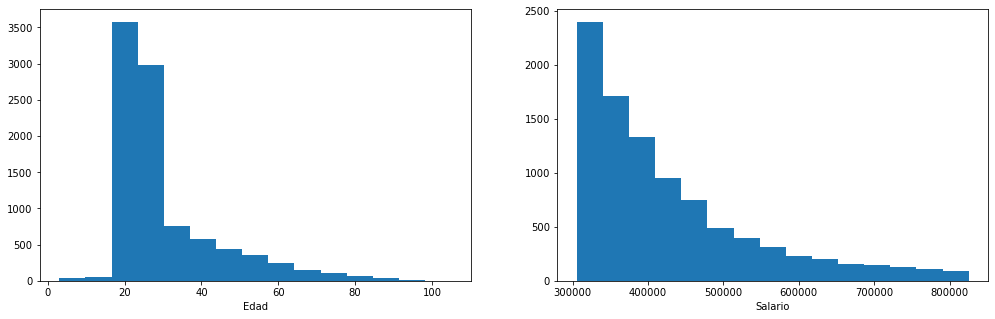

In [21]:
var_numeric = ['age','salary']

fig, ax = plt.subplots(1,2,figsize=[17,5])

ax[0].hist(cluster_4['age'],bins=15)
ax[0].set_xlabel('Edad')
ax[1].hist(cluster_4['salary'],bins=15)
ax[1].set_xlabel('Salario')
plt.show()


In [22]:
var_numeric = ['age','salary']

fig, ax = plt.subplots(figsize=[17,2])

ax.boxplot(cluster_4[var_numeric], vert=False)
plt.show()

KeyboardInterrupt: 

In [37]:
sum(cluster_7['pension_plan'])/len(cluster_7['pension_plan'])*100

4.464651558609386

In [1]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(constrained_layout=True, figsize=(13, 5))

# Axis definition
gs = GridSpec(1, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:])

ax1.text(0.00, 0.73, f'AAA', fontsize=40, color='mediumseagreen', ha='center')
ax1.text(0.00, 0.64, 'orders registered in 2017\nbetween January and August', fontsize=10, ha='center')
ax1.text(0.00, 0.40, f'BBB', fontsize=60, color='darkslateblue', ha='center')
ax1.text(0.00, 0.31, 'orders registered in 2018\nbetween January and August', fontsize=10, ha='center')
#signal = '+' if growth > 0 else '-'
ax1.text(0.00, 0.20, f'JEJEJ%', fontsize=14, ha='center', color='white', style='italic', weight='bold',
         bbox=dict(facecolor='navy', alpha=0.5, pad=10, boxstyle='round, pad=.7'))
ax1.axis('off')

# https://www.kaggle.com/thiagopanini/e-commerce-sentiment-analysis-eda-viz-nlp

NameError: name 'plt' is not defined

In [28]:
for x in cluster_7.columns:
    if 

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.